## Predict 2 meter temperature with sea surface temperature using transformer with multi-head attention
This notebook serves as an example of a basic workflow of data driven forecasting using deep learning with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with multi-head attention transformer. <br>

<img src="../assets/concept_test_case.png" alt="usecase" width="500"/>

This recipe includes the following steps:
- [Define a calendar (`lilio`)](#1---define-a-calendar-with-lilio)
- [Download/load input data (test data, accessible via `era5cli`)](#2---load-datasets)
- [Map the calendar to the data (`lilio`)](#3---map-the-calendar-to-the-data)
- [Slice and preprocess data (`s2spy`)](#4---slice-and-preprocess-data)
- [Reshape input data](#5---slice-and-reshape-input-data-for-the-transformer)
- [Specify hyper-parameters (`wandb`)](#6---hyper-parameter-tuning-with-wb)
- [Create transformer model (`torch`)](#7---create-the-transformer-model)
- [Train model (`torch`)](#8---train-the-model)
- [Evaluate the model](#9---evaluate-the-model)
- [Save the model (`onnx`)](#10---save-the-model-to-onnx)

The workflow is illustrated below:

<img src="../assets/dl.PNG" alt="Transformer" width="900"/>

### 0 - Libraries

In [1]:
import lilio
import numpy as np
import sys
import time as tt
import wandb
import urllib
import xarray as xr
from s2spy import preprocess
import torch
from torch import nn
from pathlib import Path

sys.path.append("../src/")
from transformer import Transformer
import utils

### 1 - Define a calendar with `lilio`

Specify a time range for precursor and target intervals. For more information on how this works, you can read the [lilio](https://lilio.readthedocs.io/en/latest/) documentation. 

In this example, we are creating a calendar with an anchor date of 8th January, a target of 30 days and 8 precursor intervals of 1 month each. 

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [3]:
# check calendar
calendar

Calendar(
    anchor='08-01',
    allow_overlap=True,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='0d'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M')
    ]
)

### 2 - Load datasets

Load Sea Surface Temperature (`sst`) over the Pacific Ocean and (clustered) 2m air temperature data (`t2m`) of the southwestern USA. Here we use data from 1959-2021 (63 years total). 

In [4]:
def load_data(url, field, var):
    '''Download a netCDF file from a URL and open a variable as xr.DataArray.'''
    url_field = url + field
    urllib.request.urlretrieve(url_field, field)
    dataset = xr.open_dataset(field)
    dataarray = dataset[var]
    return dataarray 

In [5]:
# URL of the dataset from zenodo
url = "https://zenodo.org/record/8186914/files/"

sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc" # Pacific Ocean SST
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc" # Southwestern USA T2M

In [6]:
precursor_field = load_data(url, sst_field, "sst")
target_field = load_data(url, t2m_field, "t2m").sel(cluster=3)

### 3 - Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

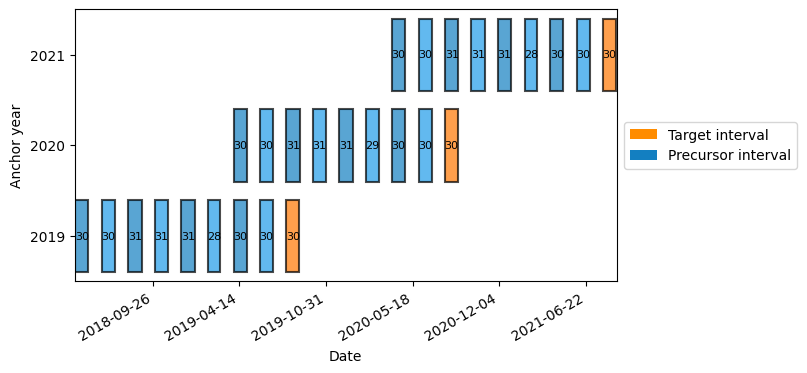

In [7]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [8]:
calendar.show()[:3]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2021,"[2020-04-01, 2020-05-01)","[2020-06-01, 2020-07-01)","[2020-08-01, 2020-09-01)","[2020-10-01, 2020-11-01)","[2020-12-01, 2021-01-01)","[2021-02-01, 2021-03-01)","[2021-04-01, 2021-05-01)","[2021-06-01, 2021-07-01)","[2021-08-01, 2021-08-31)"
2020,"[2019-04-01, 2019-05-01)","[2019-06-01, 2019-07-01)","[2019-08-01, 2019-09-01)","[2019-10-01, 2019-11-01)","[2019-12-01, 2020-01-01)","[2020-02-01, 2020-03-01)","[2020-04-01, 2020-05-01)","[2020-06-01, 2020-07-01)","[2020-08-01, 2020-08-31)"
2019,"[2018-04-01, 2018-05-01)","[2018-06-01, 2018-07-01)","[2018-08-01, 2018-09-01)","[2018-10-01, 2018-11-01)","[2018-12-01, 2019-01-01)","[2019-02-01, 2019-03-01)","[2019-04-01, 2019-05-01)","[2019-06-01, 2019-07-01)","[2019-08-01, 2019-08-31)"


### 4 - Slice and preprocess data
In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

Here we split the data into a 60%/20%/20% train-validate-test split based on anchor years, preprocess the data and resample it to the calendar to prepare the input for the model. 

In [9]:
def train_test_split(calendar, field):
    """Split data into train and test sets based on calendar intervals."""
    years = sorted(calendar.get_intervals().index)
    start_year = years[0]
    end_year = years[-1]

    # get 60% of instance as training
    train_samples = round(len(years) * 0.6)
    test_samples = round(len(years) * 0.2)
    train = field.sel(time=slice(str(start_year), str(start_year + train_samples - 1)))
    test = field.sel(time=slice(str(start_year + train_samples), str(end_year - test_samples)))
    valid = field.sel(time=slice(str(end_year - test_samples), str(end_year -1)))

    return train, test, valid

def preprocess_data(preprocessor, X_data, y_data):
    """Remove trend and resample data to the calendar."""
    calendar.map_to_data(X_data)
    preprocessor.fit(X_data)
    prep = preprocessor.transform(X_data)

    X_resample = lilio.resample(calendar, prep)
    y_resample = lilio.resample(calendar, y_data)
    return X_resample, y_resample

In [10]:
# Create train-test-validaton split
train_slice, test_slice, valid_slice = train_test_split(calendar, precursor_field)
target_train_slice, target_test_slice, target_valid_slice = train_test_split(calendar, target_field)

In [11]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

In [12]:
# Preprocess data and resample to the calendar
precursor_field_resample, target_field_resample = preprocess_data(preprocessor, train_slice, target_train_slice)
test_resample, target_test_resample = preprocess_data(preprocessor, test_slice, target_test_slice)
valid_resample, target_valid_resample = preprocess_data(preprocessor, valid_slice, target_valid_slice)

/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/s2spy/preprocess.py:158: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/s2spy/preprocess.py:158: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/s2spy/preprocess.py:158: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(


### 5 - Reshape input data for the transformer

Reshape the splits to create pytorch train, test, validate datasets.


In [13]:
def reshape_data(X_data, y_data):
    """Reshape data for pytorch model."""
    sequence_precursor = len(X_data.i_interval) - 1 # we only take precursor parts of i intervals
    lat = len(X_data.latitude)
    lon = len(X_data.longitude)

    X_torch = torch.from_numpy(X_data[:,:-1,:,:].data).type(torch.FloatTensor)
    y_torch = torch.from_numpy(y_data[:,-1].data).type(torch.FloatTensor)

    X_torch = X_torch.view(-1, sequence_precursor, lat*lon)
    y_torch = y_torch.unsqueeze(1).unsqueeze(1).repeat(1, 1, lat*lon)

    # turn nan to 0.0
    X_torch = torch.nan_to_num(X_torch, 0.0)
    return X_torch, y_torch

In [14]:
# reshape data
train_X_torch, train_y_torch = reshape_data(precursor_field_resample, target_field_resample)
valid_X_torch, valid_y_torch = reshape_data(valid_resample, target_valid_resample)
test_X_torch, test_y_torch = reshape_data(test_resample, target_test_resample)

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

### 6 - Hyper-parameter tuning with W&B
System info and syncronize training information with [W&B server](https://docs.wandb.ai/), which is a tool for tracking experiments, version and iterate machine learning experiments, as well as evaluate model performance.

In [15]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 2.3.1
Is CUDA available? False
Device to be used for computation: cpu


Define hyperparameters, initialize config for wandb and syncronize training information with W&B server. If you have an API key and a login, you can uncomment the lines `wandb.login()`  and change `mode = 'disabled'` to `mode = 'online'`, to synchronise training. Otherwise, keep those lines commented.  

In [16]:
# call weights & biases service
#wandb.login()

lat_precursor = len(precursor_field_resample.latitude)
lon_precursor = len(precursor_field_resample.longitude)

hyperparameters = dict(
    epoch = 125,
    num_encoder_layers = 1,
    num_decoder_layers = 1,
    dim_model = lat_precursor*lon_precursor,
    num_heads = 1,
    dim_feedforward = 12,
    batch_size = 10,
    dropout = 0.1,
    learning_rate = 0.01,
    periods_of_interest = periods_of_interest,
    dataset = 'Weather',
    architecture = 'Transformer'
)

# initialize weights & biases service
#mode = 'online'
mode = 'disabled'
wandb.init(config=hyperparameters, project='test-transformer', entity='ai4s2s', mode=mode)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [17]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

### 7 - Create the transformer model
Create transformer. Initialize model and choose loss function and optimizer. <br>

The architecture of the transformer is illustrated in the figure below, which is from the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762).

<img src="../assets/transformer.webp" alt="Transformer" width="500"/>

In [18]:
# Initialize model
model = Transformer(num_encoder_layers = config["num_encoder_layers"],
                    num_decoder_layers = config["num_decoder_layers"],
                    dim_model = config["dim_model"], 
                    num_heads = config["num_heads"], 
                    dim_feedforward = config["dim_feedforward"], 
                    dropout = config["dropout"])
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): Residual(
          (sublayer): MultiHeadAttention(
            (heads): ModuleList(
              (0): AttentionHead(
                (q): Linear(in_features=65, out_features=65, bias=True)
                (k): Linear(in_features=65, out_features=65, bias=True)
                (v): Linear(in_features=65, out_features=65, bias=True)
              )
            )
            (linear): Linear(in_features=65, out_features=65, bias=True)
          )
          (norm): LayerNorm((65,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): Residual(
          (sublayer): Sequential(
            (0): Linear(in_features=65, out_features=12, bias=True)
            (1): ReLU()
            (2): Linear(in_features=12, out_features=65, bias=True)
          )
          (norm): LayerNorm((65,)

[]

In [19]:
# display the total number of parameters
utils.total_num_param(model)
# for more details about the trainable parameter in each layer
#utils.param_trainable(model)

59694


### 8 - Train the model

Now we can train the model using the training set that we created. Then we switch the model into eval mode for cross-validation with the validation set. We can then plot the training and validation loss against eachother. 

In [20]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        if batch_idx % 2 == 0:
            print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
                  f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
            loss = criterion(output, var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

Epoch : 0 [0/36(0%)]	Loss: 87444.593750
Epoch : 0 [20/36(50%)]	Loss: 87112.765625
Epoch : 1 [0/36(0%)]	Loss: 86021.132812
Epoch : 1 [20/36(50%)]	Loss: 85657.000000
Epoch : 2 [0/36(0%)]	Loss: 84488.148438
Epoch : 2 [20/36(50%)]	Loss: 83976.101562
Epoch : 3 [0/36(0%)]	Loss: 82669.226562
Epoch : 3 [20/36(50%)]	Loss: 82029.156250
Epoch : 4 [0/36(0%)]	Loss: 80531.914062
Epoch : 4 [20/36(50%)]	Loss: 79766.187500
Epoch : 5 [0/36(0%)]	Loss: 78118.304688
Epoch : 5 [20/36(50%)]	Loss: 77138.968750
Epoch : 6 [0/36(0%)]	Loss: 75393.929688
Epoch : 6 [20/36(50%)]	Loss: 74263.726562
Epoch : 7 [0/36(0%)]	Loss: 72353.695312
Epoch : 7 [20/36(50%)]	Loss: 71090.867188
Epoch : 8 [0/36(0%)]	Loss: 69019.460938
Epoch : 8 [20/36(50%)]	Loss: 67539.929688
Epoch : 9 [0/36(0%)]	Loss: 65363.859375
Epoch : 9 [20/36(50%)]	Loss: 63742.972656
Epoch : 10 [0/36(0%)]	Loss: 61430.726562
Epoch : 10 [20/36(50%)]	Loss: 59682.890625
Epoch : 11 [0/36(0%)]	Loss: 57267.574219
Epoch : 11 [20/36(50%)]	Loss: 55400.617188
Epoch : 12 [

Now let's check the training loss and validation loss.

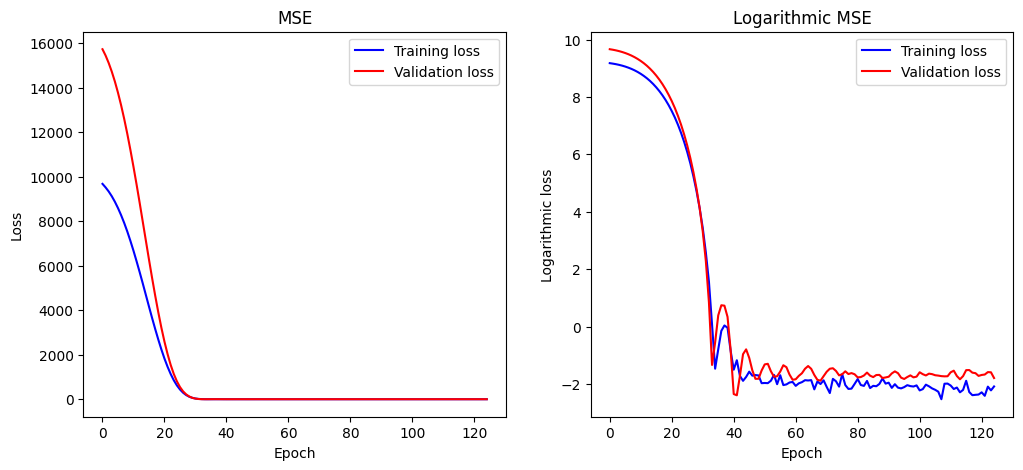

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("MSE")
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(np.log(np.asarray(hist_train)), 'b', label="Training loss")
plt.plot(np.log(np.asarray(hist_valid)), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Logarithmic loss')
plt.title("Logarithmic MSE")
plt.legend()

plt.show()

In [22]:
# save the checkpoint model training

output_path = Path.cwd().parent / "models"
output_path.mkdir(parents=True, exist_ok=True)

checkpoint_path = output_path / 'transformer_train_checkpoint.pt'

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, checkpoint_path)

### 9 - Evaluate the model
Now we can evaluate our model with the testing set and compare the predictions with the ground truth (y component of the testing set).

In [23]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = torch.autograd.Variable(X_batch).to(device)
    var_y_batch = torch.autograd.Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(torch.mean(output.squeeze(), dim=1).cpu().detach().numpy())
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

The MSE loss is 0.141


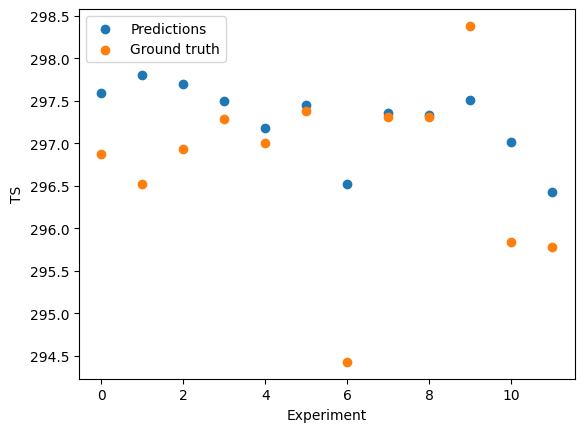

In [24]:
print(f"The MSE loss is {hist_test[0]:.3f}")

fig = plt.figure()
instances = np.arange(len(np.concatenate(predictions)))
plt.scatter(instances, np.concatenate(predictions), label="Predictions")
plt.scatter(instances, np.mean(test_y_torch.squeeze().numpy(), 1), label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()

### 10 - Save the model to ONNX

Finally, we can save the model to [ONNX](https://onnx.ai/) so that we can use the model again. We then also load and run the model again to check that this was done correctly. 

In [25]:
import onnxruntime as ort
import torch.onnx as torch_onnx

# Export the model
model_path = output_path / 'transformer_model.onnx'
torch_onnx.export(model, (test_X_torch, test_X_torch.clone()[:,-1:,:]), model_path)

/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/torch/onnx/utils.py:631: UserWarning: ONNX Preprocess - Removing mutation from node aten::add_ on block input: '0'. This changes graph semantics. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/jit/passes/onnx/remove_inplace_ops_for_onnx.cpp:355.)
  _C._jit_pass_onnx_remove_inplace_ops_for_onnx(graph, module)
/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/torch/onnx/utils.py:631: UserWarning: ONNX Preprocess - Removing mutation from node aten::add_ on block input: '1'. This changes graph semantics. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/jit/passes/onnx/remove_inplace_ops_for_onnx.cpp:355.)
  _C._jit_pass_onnx_remove_inplace_ops_for_onnx(graph, module)


Now let's load the model and plot the means of the outputs as was done earlier.

In [27]:
# Load the ONNX model
session = ort.InferenceSession(model_path)

# Run the model
input_names = [i.name for i in session.get_inputs()]
inputs = {input_names[0]: test_X_torch.cpu().detach().numpy(), input_names[1]: test_X_torch.clone()[:,-1:,:].cpu().detach().numpy()}
outputs = session.run(None, inputs)[0]

# Take the mean of each instance for plotting
outputs_mean = []
for i in outputs:
    outputs_mean.append(i[0].mean())

print(outputs_mean)

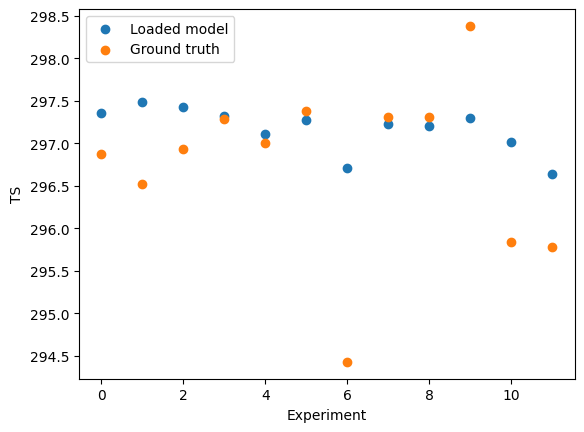

In [29]:
fig = plt.figure()
instances = np.arange(len(np.concatenate(predictions)))
plt.scatter(np.arange(len(outputs_mean)), outputs_mean, label ="Loaded model")
plt.scatter(instances, np.mean(test_y_torch.squeeze().numpy(), 1), label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()